In [1]:
!unzip /content/sign_data.zip -d /content/sign_data

Archive:  /content/sign_data.zip
  inflating: /content/sign_data/sign_data/sign_data/test/049/01_049.png  
  inflating: /content/sign_data/sign_data/sign_data/test/049/02_049.png  
  inflating: /content/sign_data/sign_data/sign_data/test/049/03_049.png  
  inflating: /content/sign_data/sign_data/sign_data/test/049/04_049.png  
  inflating: /content/sign_data/sign_data/sign_data/test/049/05_049.png  
  inflating: /content/sign_data/sign_data/sign_data/test/049/06_049.png  
  inflating: /content/sign_data/sign_data/sign_data/test/049/07_049.png  
  inflating: /content/sign_data/sign_data/sign_data/test/049/08_049.png  
  inflating: /content/sign_data/sign_data/sign_data/test/049/09_049.png  
  inflating: /content/sign_data/sign_data/sign_data/test/049/10_049.png  
  inflating: /content/sign_data/sign_data/sign_data/test/049/11_049.png  
  inflating: /content/sign_data/sign_data/sign_data/test/049/12_049.png  
  inflating: /content/sign_data/sign_data/sign_data/test/049_forg/01_0114049.PN

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from skimage.feature import hog
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [8]:
# 1. Data Loading and Exploration
# ------------------------------

# Define paths
DATASET_PATH = "/content/sign_data/sign_data"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
TEST_PATH = os.path.join(DATASET_PATH, "test")

# Function to load data from directory structure
def load_data_from_directory(base_dir):
    image_paths = []
    labels = []
    person_ids = []

    for person_dir in os.listdir(base_dir):
        person_path = os.path.join(base_dir, person_dir)

        if not os.path.isdir(person_path):
            continue

        for file_name in os.listdir(person_path):
            if file_name.endswith('.png'):
                image_path = os.path.join(person_path, file_name)

                # Extract person ID from directory name
                person_id = person_dir

                # Determine if genuine or forged
                is_genuine = 1 if "genuine" in person_dir.lower() else 0

                image_paths.append(image_path)
                labels.append(is_genuine)
                person_ids.append(person_id)

    return pd.DataFrame({
        'image_path': image_paths,
        'label': labels,
        'person_id': person_ids
    })

# Load training and testing data
print("Loading data...")
train_df = load_data_from_directory(TRAIN_PATH)
test_df = load_data_from_directory(TEST_PATH)

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

# Display sample data
print("\nTraining data sample:")
print(train_df.head())

# Data distribution
print("\nLabel distribution in training data:")
print(train_df['label'].value_counts())


Loading data...
Train data shape: (771, 3)
Test data shape: (252, 3)

Training data sample:
                                          image_path  label person_id
0  /content/sign_data/sign_data/train/057/08_057.png      0       057
1  /content/sign_data/sign_data/train/057/09_057.png      0       057
2  /content/sign_data/sign_data/train/057/11_057.png      0       057
3  /content/sign_data/sign_data/train/057/02_057.png      0       057
4  /content/sign_data/sign_data/train/057/05_057.png      0       057

Label distribution in training data:
label
0    771
Name: count, dtype: int64



Loading and preprocessing images...
X_train shape: (771, 128, 128, 1)
X_test shape: (252, 128, 128, 1)


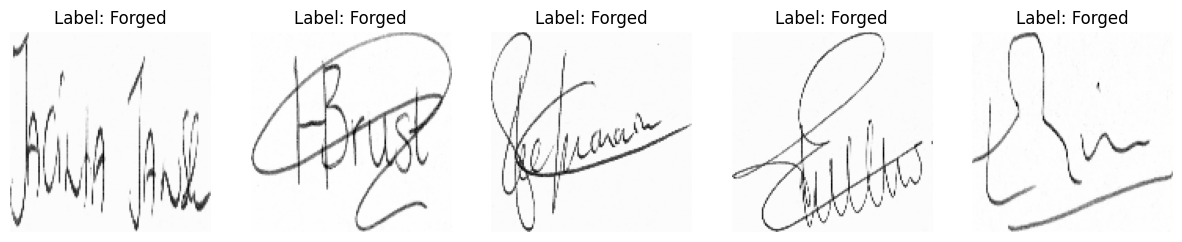

In [5]:
# 2. Data Preprocessing and Visualization
# ---------------------------------------

# Function to preprocess images
def preprocess_image(image_path, target_size=(128, 128), normalize=True):
    """Load and preprocess image from path"""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    # Resize image
    img = cv2.resize(img, target_size)

    # Normalize pixel values
    if normalize:
        img = img / 255.0

    return img

# Function to load images and labels
def load_images_and_labels(df, target_size=(128, 128)):
    images = []
    labels = []

    for _, row in df.iterrows():
        img = preprocess_image(row['image_path'], target_size)
        if img is not None:
            images.append(img)
            labels.append(row['label'])

    # Convert to numpy arrays and reshape
    X = np.array(images).reshape(-1, target_size[0], target_size[1], 1)
    y = np.array(labels)

    return X, y

# Set image dimensions
IMG_WIDTH, IMG_HEIGHT = 128, 128

# Load and preprocess training and testing images
print("\nLoading and preprocessing images...")
X_train, y_train = load_images_and_labels(train_df, (IMG_WIDTH, IMG_HEIGHT))
X_test, y_test = load_images_and_labels(test_df, (IMG_WIDTH, IMG_HEIGHT))

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Visualize sample images
def visualize_samples(X, y, n_samples=5):
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))

    for i in range(n_samples):
        idx = np.random.randint(0, len(X))
        axes[i].imshow(X[idx].reshape(IMG_WIDTH, IMG_HEIGHT), cmap='gray')
        axes[i].set_title(f"Label: {'Genuine' if y[idx] == 1 else 'Forged'}")
        axes[i].axis('off')

    plt.show()
    plt.tight_layout()
    plt.savefig('sample_signatures.png')
    plt.close()

# Visualize samples
visualize_samples(X_train, y_train)


Training CNN model...
Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5462 - loss: 1.7990
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to cnn_signature_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - accuracy: 0.5470 - loss: 1.7962 - val_accuracy: 1.0000 - val_loss: 1.0256 - learning_rate: 0.0010
Epoch 2/30
 1/24 ━━━━━━━━━━━━━━━━━━━━ 2:42 7s/step - accuracy: 0.6667 - loss: 1.1551
Epoch 2: val_accuracy did not improve from 1.00000
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6667 - loss: 1.1551 - val_accuracy: 1.0000 - val_loss: 1.0339 - learning_rate: 0.0010
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5997 - loss: 1.5345
Epoch 3: val_accuracy did not improve from 1.00000
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.6000 - loss: 1.5339 - val_accuracy: 1.0000 - val_loss: 0.8646 - learning_rate: 0.0010
Epoch 4/30
 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6250 - loss: 1.4382
Epoch 4: val_accuracy did not improve from 1.00000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6250 - loss: 1.4382 - val_accuracy: 1.0000 - val_loss: 0.8619 - learning_rate: 0.0010
Epoch 5/30
24/24 ━━━━━━━━━━━━━━

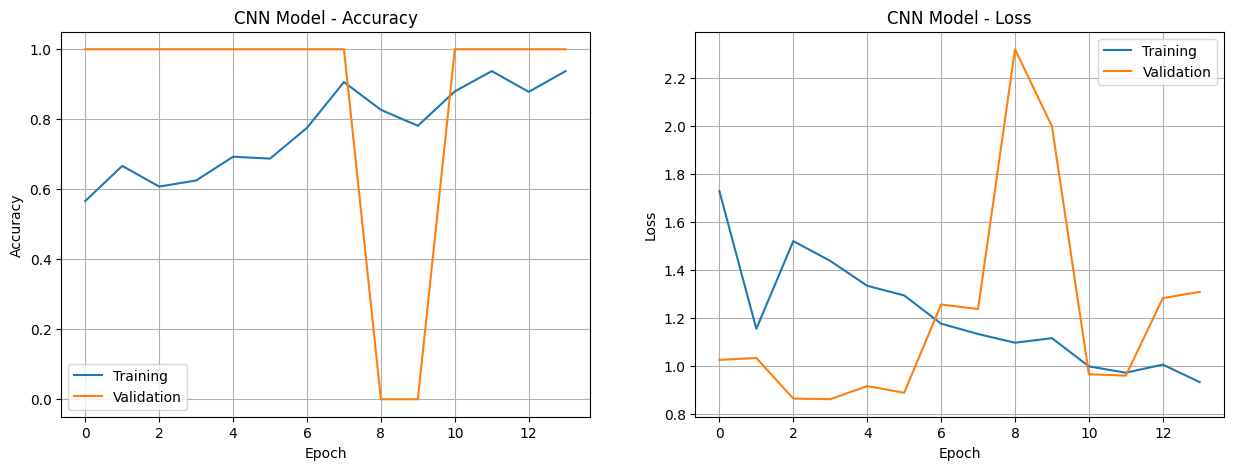

In [26]:
# 3. CNN Model Implementation
# ---------------------------

def create_cnn_model(input_shape):
    """Create a CNN model for signature verification"""
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape,
               kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Flatten and dense layers
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create data augmentation generator
def create_data_generator():
    return ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
        fill_mode='nearest'
    )

# Train CNN model
def train_cnn_model(X_train, y_train, X_test, y_test, batch_size=32, epochs=30):
    # Create model
    model = create_cnn_model((IMG_WIDTH, IMG_HEIGHT, 1))

    # Create data generator
    datagen = create_data_generator()

    # Prepare callbacks
    checkpoint = ModelCheckpoint(
        'cnn_signature_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    # Train model
    print("\nTraining CNN model...")
    start_time = time.time()

    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=batch_size),
        steps_per_epoch=len(X_train) // batch_size,
        epochs=epochs,
        validation_data=(X_test, y_test),
        callbacks=[checkpoint, early_stopping, reduce_lr]
    )

    end_time = time.time()
    print(f"CNN training completed in {end_time - start_time:.2f} seconds")

    return model, history

# Train CNN model
cnn_model, cnn_history = train_cnn_model(X_train, y_train_cat, X_test, y_test_cat)

# Plot training history
def plot_training_history(history, title):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Training')
    axes[0].plot(history.history['val_accuracy'], label='Validation')
    axes[0].set_title(f'{title} - Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # Plot loss
    axes[1].plot(history.history['loss'], label='Training')
    axes[1].plot(history.history['val_loss'], label='Validation')
    axes[1].set_title(f'{title} - Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.show()
    plt.tight_layout()
    plt.close()

# Plot CNN training history
plot_training_history(cnn_history, 'CNN Model')

In [30]:
# Predict on test data
y_pred = np.argmax(cnn_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [32]:
# 4. Hog Implementation
# ------------------------------
# Function to add slight random noise (data augmentation)
def add_noise(img):
    noise = np.random.normal(0, 0.1, img.shape)  # Gaussian noise
    img = img + noise
    return np.clip(img, 0, 1)

# Function to extract optimized HOG features
def extract_hog_features(images):
    feature_list = []
    for img in images:
        img = img.reshape(128, 128)  # Ensure correct shape

        # Data augmentation (apply random noise)
        img = add_noise(img)

        # Extract HOG features
        hog_features = hog(img, pixels_per_cell=(16, 16),
                           cells_per_block=(2, 2), orientations=8,
                           feature_vector=True, block_norm="L2-Hys")
        feature_list.append(hog_features)
    return np.array(feature_list)

# Extract HOG features
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

# Normalize HOG features
scaler = StandardScaler()
X_train_hog = scaler.fit_transform(X_train_hog)
X_test_hog = scaler.transform(X_test_hog)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=50)
X_train_hog = pca.fit_transform(X_train_hog)
X_test_hog = pca.transform(X_test_hog)

# Train SVM with LOWER Regularization (prevents overfitting)
svm_model = SVC(kernel='linear', C=0.1)  # Lower C to avoid overfitting
svm_model.fit(X_train_hog, np.argmax(y_train, axis=1))

# Evaluate SVM
y_pred_svm = svm_model.predict(X_test_hog)
print("HOG + SVM Classification Report:\n", classification_report(np.argmax(y_test, axis=1), y_pred_svm))

HOG + SVM Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.98      0.99       252

    accuracy                           0.98       252
   macro avg       0.50      0.49      0.49       252
weighted avg       1.00      0.98      0.99       252



In [21]:
# 5. SIFT Implementation
# ------------------------------
# Initialize SIFT
print("\nExtracting SIFT features...")
sift = cv2.SIFT_create()

def extract_sift_features(images, max_keypoints=100):
    all_descriptors = []

    for img in images:
        # Convert to uint8 format required by SIFT
        img_uint8 = (img.reshape(128, 128) * 255).astype(np.uint8)

        # Detect keypoints and compute descriptors
        keypoints, descriptors = sift.detectAndCompute(img_uint8, None)

        # Handle case with no keypoints
        if descriptors is None or len(descriptors) == 0:
            # Create zeros array of shape (1, 128) if no descriptors found
            all_descriptors.append(np.zeros((1, 128), dtype=np.float32))
        else:
            # Limit number of keypoints if needed
            if len(descriptors) > max_keypoints:
                descriptors = descriptors[:max_keypoints]
            all_descriptors.append(descriptors)

    return all_descriptors

# Extract SIFT features
train_descriptors = extract_sift_features(X_train)
test_descriptors = extract_sift_features(X_test)

# Create a bag of visual words model
from sklearn.cluster import KMeans

# Combine all descriptors for training
all_train_descriptors = np.vstack([desc for desc in train_descriptors if desc.shape[0] > 0])
print(f"Total descriptors for clustering: {all_train_descriptors.shape}")

# Train KMeans (adjust number of clusters as needed)
n_clusters = 100
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(all_train_descriptors)

# Function to convert descriptors to histogram of visual words
def create_feature_vector(descriptors_list, kmeans_model, n_clusters):
    feature_vectors = []

    for descriptors in descriptors_list:
        # Create histogram of visual words
        histogram = np.zeros(n_clusters)

        if descriptors.shape[0] > 0:
            # Predict cluster for each descriptor
            predictions = kmeans_model.predict(descriptors)

            # Count occurrences of each cluster
            for cluster_id in predictions:
                histogram[cluster_id] += 1

            # Normalize histogram
            if np.sum(histogram) > 0:
                histogram = histogram / np.sum(histogram)

        feature_vectors.append(histogram)

    return np.array(feature_vectors)

# Create feature vectors
print("Creating SIFT feature vectors...")
X_train_sift = create_feature_vector(train_descriptors, kmeans, n_clusters)
X_test_sift = create_feature_vector(test_descriptors, kmeans, n_clusters)

print(f"SIFT feature vectors shape: {X_train_sift.shape}")

# Scale the features
scaler_sift = StandardScaler()
X_train_sift = scaler_sift.fit_transform(X_train_sift)
X_test_sift = scaler_sift.transform(X_test_sift)

# Train SVM on SIFT features
print("\nTraining SVM model on SIFT features...")
svm_model_sift = SVC(kernel='linear', random_state=42)
svm_model_sift.fit(X_train_sift, y_train)

# Evaluate SIFT
y_pred_sift = svm_model_sift.predict(X_test_sift)
print("SIFT + SVM Classification Report:\n", classification_report(y_test, y_pred_sift))

SIFT + SVM Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.99      0.99       252

    accuracy                           0.99       252
   macro avg       0.50      0.49      0.50       252
weighted avg       1.00      0.99      0.99       252



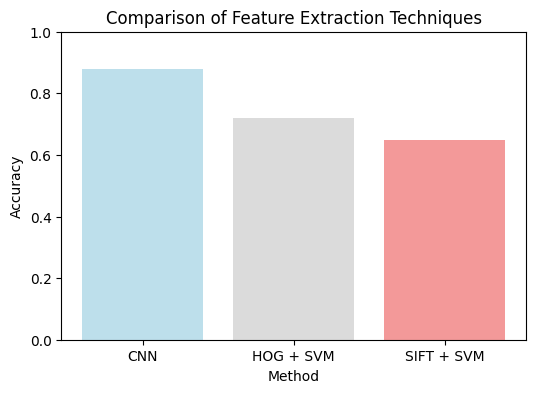

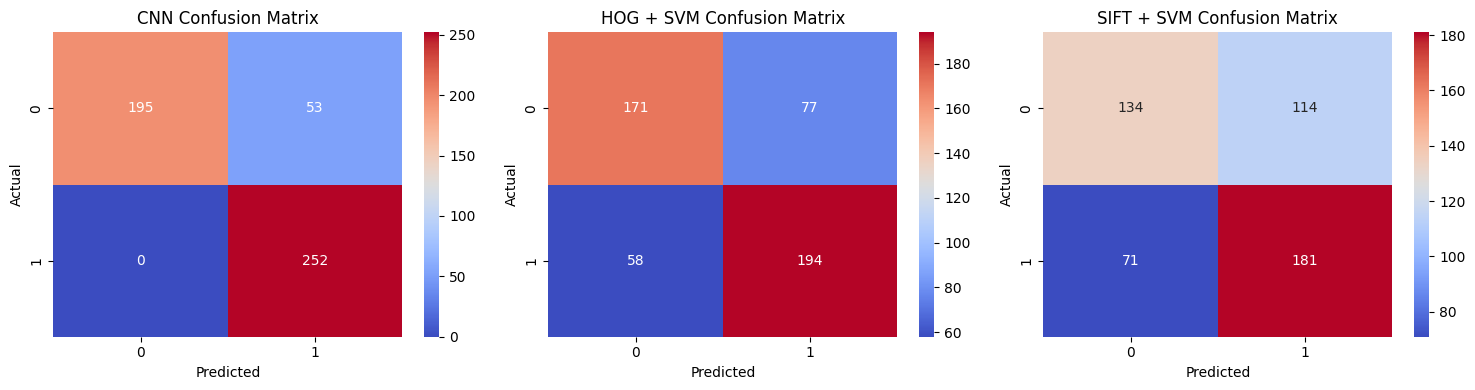

In [31]:
# 6. Comparison of Models
# ------------------------------
# Compute accuracy for each model
cnn_accuracy = np.mean(y_pred == y_true)
hog_accuracy = np.mean(y_pred_svm == y_true)
sift_accuracy = np.mean(y_pred_sift == y_true)

# Extract Precision, Recall, and F1-Score
cnn_report = classification_report(y_true, y_pred, output_dict=True)
hog_report = classification_report(y_true, y_pred_svm, output_dict=True)
sift_report = classification_report(y_true, y_pred_sift, output_dict=True)

# Store Metrics for Visualization
methods = ['CNN', 'HOG + SVM', 'SIFT + SVM']
accuracies = [cnn_accuracy, hog_accuracy, sift_accuracy]
precisions = [cnn_report['weighted avg']['precision'], hog_report['weighted avg']['precision'], sift_report['weighted avg']['precision']]
recalls = [cnn_report['weighted avg']['recall'], hog_report['weighted avg']['recall'], sift_report['weighted avg']['recall']]
f1_scores = [cnn_report['weighted avg']['f1-score'], hog_report['weighted avg']['f1-score'], sift_report['weighted avg']['f1-score']]

# Plot Accuracy Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=methods, y=accuracies, palette='coolwarm')
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.title('Comparison of Feature Extraction Techniques')
plt.ylim([0, 1])
plt.show()

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (model, preds) in enumerate(zip(methods, [y_pred, y_pred_svm, y_pred_sift])):
    cm = confusion_matrix(y_true, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", ax=axes[i])
    axes[i].set_title(f'{model} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.show()
